In [3]:
from __future__ import division
import numpy as np
import nltk
import pickle
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
from find_keys import load_data,_removeNonAscii, split_text

Data=load_data('/Users/parisa/Documents/inspires_project/inspire/big')

with open('/Users/parisa/Documents/inspires_project/inspire/keyword_occurancesBIG.pkl','rb') as f:
        mydata= np.asarray(pickle.load(f))
target=mydata[:,10]
blank=[]
for i in range(len(target)):
    if target[i]=='':
        blank.append(i)

data=np.delete(Data,blank)
split=split_text(data)
#print ((split)[817]['abstract'])
X=[]
split2=[]
for i in range(len(split)):
    #del file['decision']
    if split[i]['abstract']!='':
        split2.append(split[i])
        X.append(split[i]['abstract'])
        
    
Y=[]
for files in split2:
    if files['decision']=='CORE':
        Y.append(2)
    elif files['decision']=='Non-CORE':
        Y.append(1)
    else:
        Y.append(0)



Continuous-wave mode-locked femtosecond 2 um solid-state laser with a c-cut Tm:CaYAlO4 as gain medium was experimentally demonstrated The mode locked laser generated stable pulses with average output power as high as 531 mW pulse duration of 496 fs and repetition rate of 97 MHz at 1975 nm The research results show that Tm:CaYAlO4 is an excellent gain medium for femtosecond pulse generation at 2um wavelength


In [5]:
def rejected(stream):
    for i,n in enumerate(stream):
        if n == 0:
            yield i

rejected = list(rejected(Y))
np.random.shuffle(rejected)

to_del=rejected[:28000]

newX=np.delete(X,to_del,axis=0)
newY=np.delete(Y,to_del)

In [6]:
#print (len(newX),len(newY))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3,random_state=42,shuffle=True)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vec=CountVectorizer(stop_words='english')
X_train_counts=count_vec.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf= tfidf_transformer.fit_transform(X_train_counts)

X_test_counts=count_vec.transform(X_test)
X_test_tfidf= tfidf_transformer.transform(X_test_counts)

Try Naive Bayes classifier

In [21]:
from sklearn.naive_bayes import MultinomialNB
clf= MultinomialNB().fit(X_train_tfidf, y_train)

#cross validation
kfold = model_selection.KFold(n_splits=10, random_state=42)
cv_results = model_selection.cross_val_score(MultinomialNB(), X_train_tfidf, y_train, cv=kfold, scoring='accuracy')
print ('Naive Bayes accuracy:', np.average(cv_results))

Naive Bayes accuracy: 0.8812735749535576


Try linear SVM

In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

class_weights1={0:0.05,1:6,2:3}
class_weights2={0:0.07,1:6,2:5}
param_grid={#"C": np.linspace(start=0.1, stop=0.2,num=5),
           #'loss':('hinge','squared_hinge')
           'class_weight':(class_weights1,'balanced'),
           'multi_class':('ovr','crammer_singer')}

grid = GridSearchCV(LinearSVC(C=0.175),param_grid=param_grid,scoring="accuracy", cv=3)
grid.fit(X_train_tfidf, y_train)
y_pred= grid.predict(X_test_tfidf)


In [11]:
print('Best score: %0.3f'% grid.best_score_)
print('Best parameters set:')
best_params = grid.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(param_name,best_params[param_name])

Best score: 0.922
Best parameters set:
class_weight balanced
multi_class ovr


Test linear SVM performace

In [12]:
from sklearn.metrics import cohen_kappa_score
target_names=['Rejected','NON-CORE', 'CORE']
target_labels=[0,1,2]
report= classification_report(y_test,y_pred,labels=target_labels,target_names=target_names)
kappa = cohen_kappa_score(y_test,y_pred)
print (report)
print ('cohen kappa score:', '%.2f' % kappa)

             precision    recall  f1-score   support

   Rejected       0.95      0.98      0.96      9106
   NON-CORE       0.47      0.29      0.36       628
       CORE       0.81      0.81      0.81       616

avg / total       0.91      0.93      0.92     10350

cohen kappa score: 0.63


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm=confusion_matrix(y_test,y_pred,labels=[0,1,2],)
print (cm)

[[8898  165   43]
 [ 372  182   74]
 [  77   42  497]]


In [14]:
import itertools

def plot_confusion_matrix(cm, classes,normalize=False,title='confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix")
    print (cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment='center',color='white' if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')        

In [15]:
def Analyze(classifier,X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import classification_report
    clf=classifier.fit(X_train,Y_train)
   # score=clf.score(X_test,Y_test)
    Y_pred=clf.predict(X_test)
    target_names=['Rejected','NON-CORE','CORE']
    target_labels=[0,1,2]
    reporst=classification_report(Y_test,Y_pred,labels=target_labels,target_names=target_names)
    cm=cm=confusion_matrix(Y_test,Y_pred,labels=[0,1,2])
    plt.figure()
    plot_confusion_matrix(cm,classes=target_names,normalize=True)
    plt.show()
    print(report)

Normalised confusion matrix
[[0.97715792 0.01811992 0.00472216]
 [0.59235669 0.28980892 0.11783439]
 [0.125      0.06818182 0.80681818]]


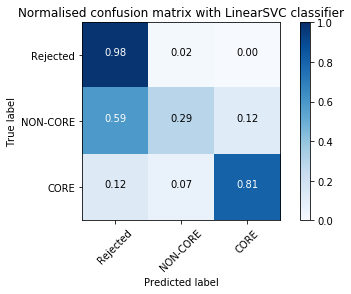

In [16]:
plt.figure()
plot_confusion_matrix(cm,classes=target_names,normalize=True,title='Normalised confusion matrix with LinearSVC classifier')
#plt.savefig('BoW_cm_LinSVC',pad_inches=0.2, bbox_inches='tight',dpi=200)
plt.show()

In [17]:
def modeltesting(X_train, X_validation, Y_train, Y_validation):
    '''Function to test different models and produce a box plot to show the accuracies'''
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neural_network import MLPClassifier
    from sklearn.svm import LinearSVC
    from sklearn.linear_model import SGDClassifier
    from sklearn.svm import SVC
    scoring = 'accuracy'
    # Spot Check Algorithms
    models = []
    models.append(('LogisticRegression', LogisticRegression()))
    #models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    #models.append(('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()))
    #models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    #models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    #models.append(('Naive Bayes', GaussianNB()))
    #models.append(('Neural Network', MLPClassifier()))
    models.append(('LinearSVC', LinearSVC(max_iter=10,class_weight='balanced')))
    models.append(('SGDClassifier', SGDClassifier(max_iter=10,class_weight='balanced',loss='log',penalty='elasticnet')))
    #models.append(('SVC', SVC(class_weight='balanced')))
    
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=42)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())    
        print(msg)
        Analyze(model,X_train,Y_train,X_validation,Y_validation)
        
        
        
    fig = plt.figure()
    #fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    #pyplot.legend()
    plt.ylabel('Accuracy')
    ax.set_xticklabels(names,rotation=13)
    plt.show()


LogisticRegression: 0.913119 (0.006657)
Normalised confusion matrix
[[5.89285714e-01 8.11688312e-03 4.02597403e-01]
 [5.73248408e-02 2.70700637e-02 9.15605096e-01]
 [1.75708324e-03 2.19635405e-04 9.98023281e-01]]


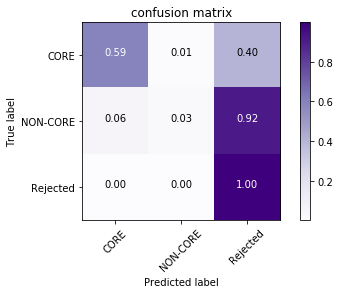

             precision    recall  f1-score   support

       CORE       0.81      0.81      0.81       616
   NON-CORE       0.47      0.29      0.36       628
   Rejected       0.95      0.98      0.96      9106

avg / total       0.91      0.93      0.92     10350

Neural Network: 0.920490 (0.009210)
Normalised confusion matrix
[[0.74188312 0.06493506 0.19318182]
 [0.10350318 0.21496815 0.68152866]
 [0.00362398 0.01295849 0.98341753]]


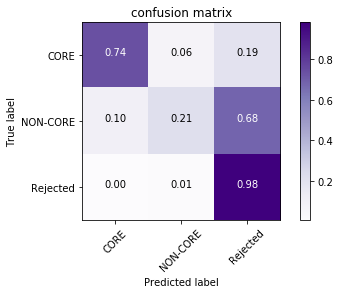

             precision    recall  f1-score   support

       CORE       0.81      0.81      0.81       616
   NON-CORE       0.47      0.29      0.36       628
   Rejected       0.95      0.98      0.96      9106

avg / total       0.91      0.93      0.92     10350

LinearSVC: 0.920821 (0.007211)
Normalised confusion matrix
[[0.79383117 0.07467532 0.13149351]
 [0.11305732 0.30732484 0.57961783]
 [0.00439271 0.02284208 0.97276521]]


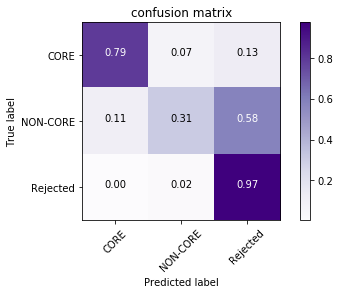

             precision    recall  f1-score   support

       CORE       0.81      0.81      0.81       616
   NON-CORE       0.47      0.29      0.36       628
   Rejected       0.95      0.98      0.96      9106

avg / total       0.91      0.93      0.92     10350

SGDClassifier: 0.920904 (0.007804)
Normalised confusion matrix
[[0.72077922 0.05194805 0.22727273]
 [0.10350318 0.18949045 0.70700637]
 [0.00417307 0.00977378 0.98605315]]


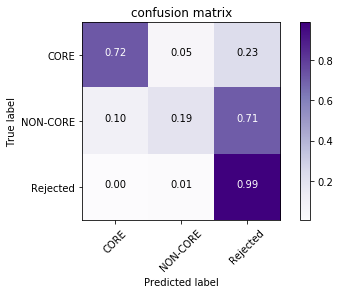

             precision    recall  f1-score   support

       CORE       0.81      0.81      0.81       616
   NON-CORE       0.47      0.29      0.36       628
   Rejected       0.95      0.98      0.96      9106

avg / total       0.91      0.93      0.92     10350



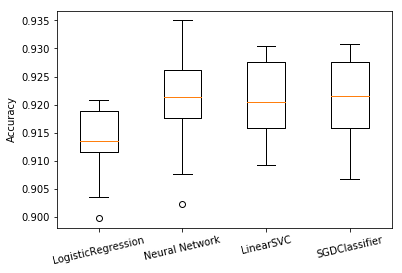

In [15]:
modeltesting(X_train_tfidf, X_test_tfidf, y_train, y_test)

ROC curve for linear SVM

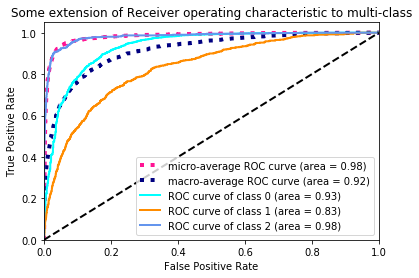

In [20]:
# Compute macro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize
# First aggregate all false positive rates
n_classes=3
y_bin_test=label_binarize(y_test,classes=[0,1,2])
#y_bin_pred=label_binarize(y_pred,classes=[0,1,2])
y_bin_pred = grid.fit(X_train_tfidf, y_train).decision_function(X_test_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_test.ravel(), y_bin_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    lw = 2
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()